# Demonstration of DCBC evaluation usage in volume space
This notebook shows an example of a Distance controlled boundary coefficient (DCBC) evaluation of a striatum parcellation using the Multi-domain task battery (MDTB) functional dataset (glm7). 

## Installation and Requirments

Ensure Python version >= 3.6 and pip installed on your system.

- Install Python at https://www.python.org/downloads/
- Install pip: https://pip.pypa.io/en/stable/installing/

## Dependencies

`pip install nibabel scipy numpy sklearn matplotlib`

## Usage
Below is a quick sample script of using the DCBC evaluation for evaluating `Choi 2012` 7 parcellation of striatum.

In [2]:
import numpy as np
import scipy as sp
from DCBC_vol import compute_dist, compute_DCBC
import nibabel as nb
import mat73
from plotting import plot_single

# Load mask voxel index
vol_ind = mat73.loadmat('data/striatum_avrgDataStruct.mat')['volIndx']
vol_ind = vol_ind.astype(int)


data type not supported: struct, uint64


The file `striatum_avrgDataStruct.mat` is the pre-processed data structure of our MDTB fmri data on striatum in volume space, including pre-whitened beta value and the mask volume index of the striatum. Now, we load the parcellation that we want to evaluate from the file given the volxel indices of the mask.
Note: we first need to transfer the vol index to 3d coordinates by F-order. This is because MATLAB uses row-order to perform linear indexing, while numpy uses colume order.

In [3]:
# Load parcellation given the mask file or voxel indices
parcel_mni = nb.load('parcellations/volume_striatum/masked_par_choi_7.nii.gz').get_fdata()
coord = np.unravel_index(vol_ind - 1, parcel_mni.shape, 'F')  # Note: the linear indexing in numpy is column-order
parcels = np.rint(parcel_mni[coord[0], coord[1], coord[2]])
print(parcels)

[5. 0. 5. ... 0. 6. 0.]


We also need a pairwise distance matrix of all mask voxel indices for DCBC calcluation.

In [4]:
# Compute the distance matrix between voxel pairs using the mask file, numpy default C-order
coord = np.asarray(coord).transpose()
dist = compute_dist(coord, 2)
print(dist)

[[ 0.         38.05259518 12.16552506 ... 69.3108938  67.94115101
  68.93475176]
 [38.05259518  0.         26.         ... 51.57518783 51.2249939
  50.99019514]
 [12.16552506 26.          0.         ... 62.09669879 60.95900262
  61.6116872 ]
 ...
 [69.3108938  51.57518783 62.09669879 ...  0.          2.
   2.        ]
 [67.94115101 51.2249939  60.95900262 ...  2.          0.
   2.82842712]
 [68.93475176 50.99019514 61.6116872  ...  2.          2.82842712
   0.        ]]


Here, we load subject functional data for DCBC evaluation and several experiment settings.

In [5]:
# Load functional profile (betas) and several parameters for evaluation settings
T = mat73.loadmat('data/striatum_avrgDataStruct.mat')['T']
returnsubj = [2,3,4,6,8,9,10,12,14,15,17,18,19,20,21,22,24,25,26,27,28,29,30,31]
session, maxDist, binWidth = 1, 90, 5

data type not supported: struct, uint64


Now, we start the real DCBC evaluation on the given parcellation using selected subjects and given experiment settings. So here we set the bin width = 5 mm, the maximum distance between any pair of voxels is 90 mm. We only use subjects session 1 data.

In [7]:
wcorr_array, bcorr_array, dcbc_array = np.array([]), np.array([]), np.array([])
for sub in returnsubj:
    data = T['data'][(T['SN'] == sub) & (T['sess'] == session)].transpose()
    R = compute_DCBC(maxDist=maxDist, func=data, dist=dist, binWidth=binWidth, parcellation=parcels)
    wcorr_array = np.append(wcorr_array, R['corr_within'])
    bcorr_array = np.append(bcorr_array, R['corr_between'])
    dcbc_array = np.append(dcbc_array, R['DCBC'])

# print(wcorr_array, bcorr_array, dcbc_array)

After we finished the DCBC evalaution for all subjects, we plot the un-weighted within- and between-correlation curves. A bigger gap between two curves means the given parcellation has higher quality to functionally separate the brain regions. Otherwise, the parcellation cannot functionally separate the brain obviously. In the extrame, the two curves are the same for random parcellations.

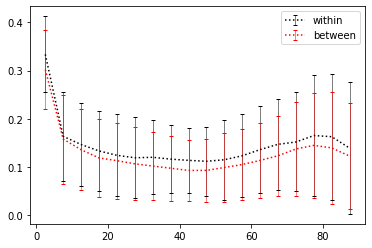

[0.01703593 0.0327379  0.00376956 0.01475464 0.00624606 0.00335091
 0.0275695  0.03244851 0.01709353 0.00131853 0.01773563 0.0115281
 0.00907436 0.04684011 0.01246886 0.01042326 0.0126392  0.01273811
 0.05126503 0.00155614 0.01637881 0.01597363 0.01455931 0.00617436]


In [10]:
%matplotlib inline
plot_single(within=wcorr_array, between=bcorr_array, maxDist=90, binWidth=5,
                subjects=returnsubj, within_color='k', between_color='r')
print(dcbc_array)